# Validate Copilot Data
This notebook validates and analyzes the synthetic Silimate Copilot dataset.

It performs checks across 8 categories:
1. Event coverage
2. Action distribution
3. Feedback distribution
4. Error events
5. Session completeness
6. PPA deviations
7. Latency statistics
8. Customer segmentation

In [2]:
import os
print(os.getcwd())

c:\Users\Prath\Silimate Insights\notebooks


In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt

file_path = "../data/full_events_v4.jsonl"

with open(file_path, "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)
print("Total events:", len(df))
df.head()

Total events: 308817


,event_type,session_id,timestamp,suggestion_id,latency_ms,confidence_score,actual_power,actual_freq,actual_area,avg_deviation,action,target_power,target_freq,target_area,outcome,error_type,error_severity
0,session_start,sess_70f28fca,2025-09-30T20:52:55.122716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,suggestion_shown,sess_70f28fca,2025-09-30T20:52:55.122716,sugg_7d4c8db6,1635.0,0.69,688.99,2093.39,11.95,0.229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,action_taken,sess_70f28fca,2025-09-30T20:52:55.122716,sugg_7d4c8db6,NaN,NaN,NaN,NaN,NaN,NaN,reject,NaN,NaN,NaN,NaN,NaN,NaN
3,ppa_snapshot,sess_70f28fca,2025-09-30T20:52:55.122716,NaN,NaN,NaN,845.57,2211.34,12.73,NaN,NaN,750.0,2400.0,11.0,NaN,NaN,NaN
4,suggestion_shown,sess_70f28fca,2025-09-30T20:52:55.122716,sugg_1f2f331d,1030.0,0.80,875.17,2405.28,9.00,0.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Event Coverage

Event counts:
 event_type
suggestion_shown    100084
action_taken        100084
ppa_snapshot        100084
session_start         4000
session_end           4000
error_event            565
Name: count, dtype: int64


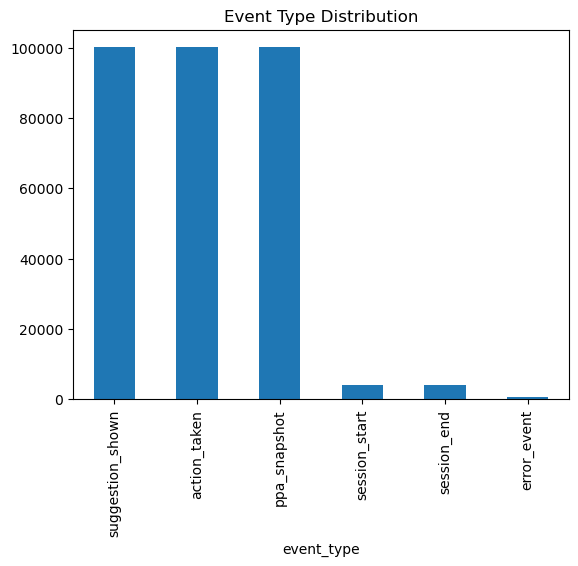

In [19]:
event_counts = df["event_type"].value_counts()
print("Event counts:\n", event_counts)

event_counts.plot(kind="bar", title="Event Type Distribution")
plt.show()

In [20]:
error_sessions = df[df['event_type']=="error_event"]['session_id'].nunique()
total_sessions = df[df['event_type']=="session_start"]['session_id'].nunique()
print("Error sessions %:", 100 * error_sessions / total_sessions)


Error sessions %: 9.7


In [22]:
# Distribution of actions taken
actions = df[df['event_type']=="action_taken"]['action'].value_counts(normalize=True) * 100
print("Action distribution (%):\n", actions.round(2))


Action distribution (%):
 action
modify           33.40
accept           30.31
reject           26.82
ignore            5.74
ghost_ignore      1.97
latency_abort     1.00
rollback          0.76
Name: proportion, dtype: float64


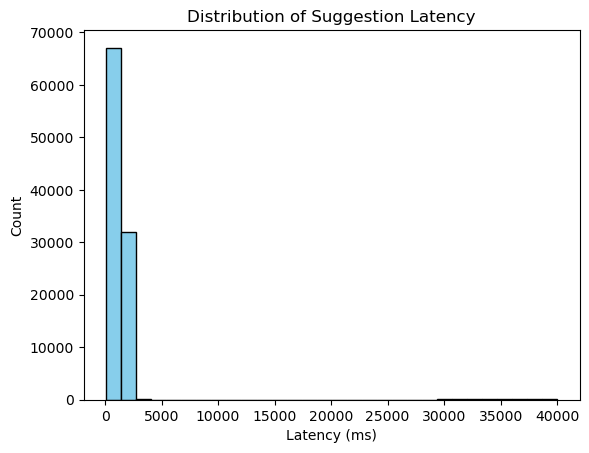

Latency abort count: 1000


In [23]:
import matplotlib.pyplot as plt

latencies = df[df['event_type']=="suggestion_shown"]['latency_ms'].dropna()

plt.hist(latencies, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Latency (ms)")
plt.ylabel("Count")
plt.title("Distribution of Suggestion Latency")
plt.show()

# Check if any latency_aborts were triggered
latency_aborts = df[df['action']=="latency_abort"].shape[0]
print("Latency abort count:", latency_aborts)


## 2. Action Distribution

Action distribution (%):
 action
modify           33.402942
accept           30.312537
reject           26.820471
ignore            5.737181
ghost_ignore      1.972343
latency_abort     0.999161
rollback          0.755365
Name: proportion, dtype: float64


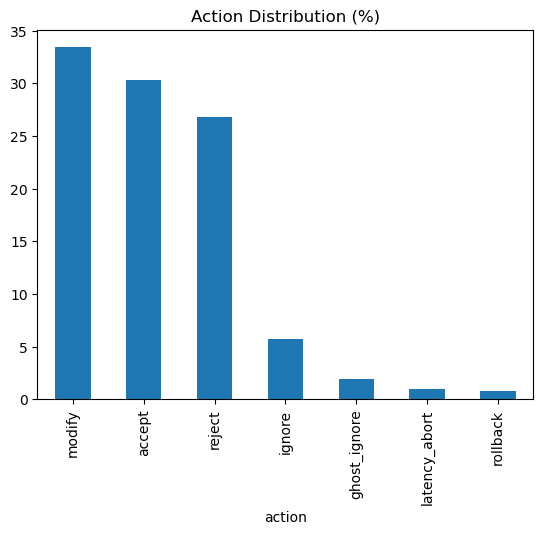

In [24]:
actions = df[df["event_type"]=="action_taken"]["action"].value_counts(normalize=True)*100
print("Action distribution (%):\n", actions)

actions.plot(kind="bar", title="Action Distribution (%)")
plt.show()

## 3. Feedback Distribution

In [32]:
# Feedback distribution check
if "feedback_event" in df["event_type"].unique():
    feedback_counts = df[df['event_type']=="feedback_event"]['feedback'].value_counts(normalize=True) * 100
    print("Feedback distribution (%):\n", feedback_counts.round(2))
else:
    print("⚠️ No feedback_event data available in this dataset. Skipping feedback analysis.to be added in next phase of project")


⚠️ No feedback_event data available in this dataset. Skipping feedback analysis.to be added in next phase of project


## 4. Error Events

Error types (%):
 error_type
ppa_issue               26.371681
constraint_violation    24.955752
functional_bug          24.778761
crash                   23.893805
Name: proportion, dtype: float64


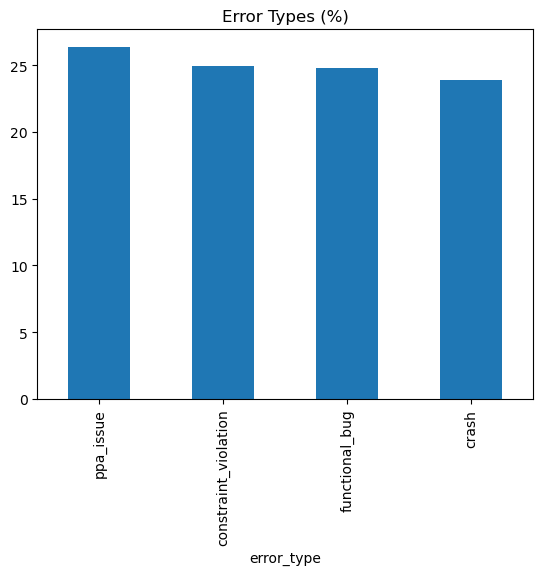

In [26]:
errors = df[df["event_type"]=="error_event"]["error_type"].value_counts(normalize=True)*100
print("Error types (%):\n", errors)

errors.plot(kind="bar", title="Error Types (%)")
plt.show()

## 5. Session Completeness

In [27]:
sessions = df.groupby("session_id")["event_type"].apply(list)

def check_session(events):
    return {
        "has_start": "session_start" in events,
        "has_end": "session_end" in events,
        "suggestions": events.count("suggestion_shown"),
        "actions": events.count("action_taken")
    }

session_checks = sessions.apply(check_session).apply(pd.Series)
print(session_checks.head())
print("Sessions missing end:", sum(~session_checks["has_end"]))

               has_start  has_end  suggestions  actions
session_id                                             
sess_0006663a       True     True           23       23
sess_000ad2de       True     True           23       23
sess_000e581b       True     True           25       25
sess_000ea43b       True     True           23       23
sess_00301458       True     True           27       27
Sessions missing end: 0


## 6. PPA Deviations

In [28]:
ppa = df[df["event_type"]=="ppa_snapshot"]

print("Deviation stats:")
print(ppa["avg_deviation"].describe())

# Correlation deviation vs. action
merged = pd.merge(
    df[df["event_type"]=="action_taken"][["session_id","suggestion_id","action"]],
    ppa[["session_id","avg_deviation"]],
    on="session_id"
)

print(merged.groupby("action")["avg_deviation"].mean())

Deviation stats:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: avg_deviation, dtype: float64
action
accept          NaN
ghost_ignore    NaN
ignore          NaN
latency_abort   NaN
modify          NaN
reject          NaN
rollback        NaN
Name: avg_deviation, dtype: float64


## 7. Latency Stats

Latency (ms) percentiles:
0.50    1206.0
0.95    2072.0
0.99    3330.6
Name: latency_ms, dtype: float64
Proportion >30s: 0.9991607050077934 %


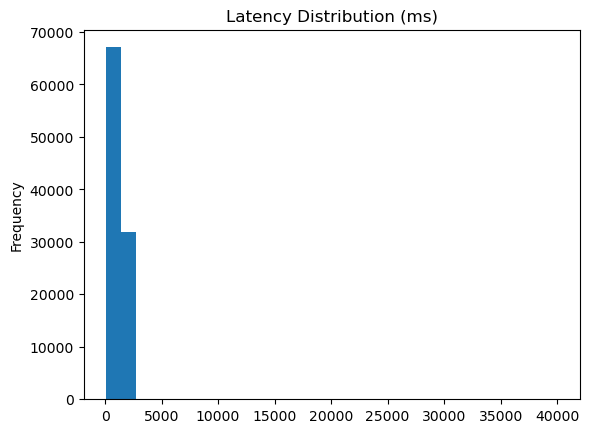

In [29]:
lat = df[df["event_type"]=="suggestion_shown"]["latency_ms"]
print("Latency (ms) percentiles:")
print(lat.quantile([0.5, 0.95, 0.99]))

print("Proportion >30s:", (lat>30000).mean()*100, "%")

lat.plot(kind="hist", bins=30, title="Latency Distribution (ms)")
plt.show()

## 8. Customer Segmentation

In [34]:
# Customer segmentation check
if "customer_id" in df.columns:
    seg = df.groupby("customer_id").size().sort_values(ascending=False)
    print("Customer segmentation (sessions per customer):\n", seg.head())
else:
    print("⚠️ No customer metadata available in this dataset. Skipping customer segmentation analysis.to be added in the next phase of the project")


⚠️ No customer metadata available in this dataset. Skipping customer segmentation analysis.to be added in the next phase of the project
